## Example of how to create ENDF library with Extinction

This example shows how to use the extinction plugin CrysExtn [1] together with the ncmat2endf script to generate an ENDF library. Extinction is included as a modification to the coherent elastic cross-section and is included via a standalone NCrystal plugin.

The coherent scattering cross-section is given by,
\begin{equation}
\sigma_{\textrm{coh}}^{\textrm{el}}(\lambda)=\dfrac{\lambda^{2}}{2V}\sum_{hkl}^{\lambda\leq 2d_{hkl}}d_{hkl}|F_{hkl}|^{2}E_{hkl}(\lambda,d_{hkl}),
\end{equation}
where $E_{hkl}(\lambda,d_{hkl})$ is the extinction factor. Several different models are available in the plugin, however this example will focus on primary extinction using the Sabine model [2,3]. More information on available models can be found in [1] in the files `README.md` and `src/NCPhysicsModel.cc`.

* [1] https://github.com/XuShuqi7/ncplugin-CrysExtn
* [2] Sabine, T. (1985). Aust. J. Phys. 38(3), 507-518
* [3] Sabine, T. (2006). International Tables for Crystallography (2006). Vol. C. ch. 6.4, pp. 609-616

## Preamble
Ensure dependencies are available (and install them if not in case of running on Google Colab). Feel free to edit as you wish.

In [1]:
import shutil
import pathlib
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    #not on google colab
    google_colab = None

if not all ( shutil.which(c) for c in ['ncrystal-config','njoy','openmc'] ):
    if not google_colab:
        raise RuntimeError(
            """Please run this notebook from an environment with both
               NCrystal, NJOY, OpenMC, and endf-parserpy installed!
               For instance, create a conda environment based on
               https://github.com/mctools/ncrystal-notebooks/blob/main/conda.yml
            """)
    print("WARNING: Installing mambaforge. This will cause your notebook "
          "to say it crashed and restart itself. This is expected behaviour!!")
    %pip -q install condacolab
    import condacolab
    condacolab.install_miniforge()
    !mamba install ncrystal njoy2016 openmc endf-parserpy

#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#Note: We do not install or import NCrystal yet, since we need to first install the extinction plugin!

Also install NCrystal notebook utilities:

In [2]:
try:
    import ncrystal_notebook_utilities
except ImportError:
    ncrystal_notebook_utilities = None
if ncrystal_notebook_utilities is None:
    %pip install ncrystal-notebook-utilities
    import ncrystal_notebook_utilities


  Using cached ncrystal_notebook_utilities-0.0.1-py3-none-any.whl.metadata (13 kB)
Using cached ncrystal_notebook_utilities-0.0.1-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


### Install the plugin and import NCrystal
Get the plugin CrysExtn and other dependencies. If we didn't know already how to do that, we could have found the plugin on https://github.com/mctools/ncrystal/wiki/CuratedPlugins.



In [3]:
%pip install "git+https://github.com/XuShuqi7/ncplugin-CrysExtn"

  Cloning https://github.com/XuShuqi7/ncplugin-CrysExtn to /tmp/pip-req-build-zf6p4e7i
  Running command git clone --filter=blob:none --quiet https://github.com/XuShuqi7/ncplugin-CrysExtn /tmp/pip-req-build-zf6p4e7i
  Resolved https://github.com/XuShuqi7/ncplugin-CrysExtn to commit 54af38baf586044024cd38a9ca268aeb2aa88879
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ncrystal_pypluginmgr-0.0.5-py3-none-any.whl.metadata (14 kB)
Using cached ncrystal_pypluginmgr-0.0.5-py3-none-any.whl (13 kB)
  Created wheel for ncrystal-plugin-CrysExtn: filename=ncrystal_plugin_crysextn-0.0.1-py3-none-linux_x86_64.whl size=50434 sha256=52a899a5b446c76e7589fac04f89d3abcfea78bd40ab3eafbc2531c73c4bb405
  Stored in directory: /tmp/pip-ephem-wheel-cache-9d8r4d74/wheels/61/98/be/e5e094e87f21855c00ef661f00ddfa25acda294b9646c72581
Successfully built ncrystal-plugin-CrysExtn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We can now finally import NCrystal (which checks for plugins when first imported). And also note that we can check the plugin is available via the Python API:

In [4]:
import NCrystal as NC
assert NC.version_num >=  4002000, "too old NCrystal found"
NC.test() #< quick unit test that installation works
NC.browsePlugins(dump=True) # dump=True means we print the list
assert any( p[0]=='CrysExtn' for p in NC.browsePlugins() ), "Error: CrysExtn plugin not available"

Tests completed succesfully
NCrystal has 9 plugins loaded.
==> stddatasrc (builtin)
==> stdscat (builtin)
==> stdmpscat (builtin)
==> stdexpscat (builtin)
==> stdlaz (builtin)
==> stdabs (builtin)
==> stdncmat (builtin)
==> stdquick (builtin)
==> CrysExtn (dynamic from /some/where/miniforge3/envs/ncrystalnotebooks/lib/python3.12/site-packages/ncrystal_plugin_CrysExtn/plugins/libNCPlugin_CrysExtn.so)


# Using the plugin
Let's create a file and set the parameters of the model.

This is done by taking an existing file and adding the relevant section for the new physics through using `c.set_custom_section_data()`.
The name of the plugin is `CRYSEXTN` followed by the data used by the model.
The `CRYSEXTN` plugin currently supports both the uncorrelated and correlated model of Sabine, however with only primary extinction active, both models are the same. This example will use the correlated model. Primary extinction is controlled by the crystallite size parameter $l$, while secondary extinction is controlled by the grain size parameter $L$ and the mosacity parameter $g$ [3]. The parameters $g$ and $L$ are set to zero for only primary extinction. $l$ and $L$ have units of Ångströms and $g$ has units of 1/rad.

The data is added to the section called `@CUSTOM_CRYSEXTN`. Sabine_corr indicates the Sabine correlated model. The first parameter is $l$, the second is $g$ and the third is $L$.

In [5]:
#Base our material from Beryllium from the NCrystal std data library:
c = NC.NCMATComposer('stdlib::Be_sg194.ncmat')
#Enable primary extinction, with 5 micron crystal domains (units are Angstrom):
c.set_custom_section_data("CRYSEXTN", " Sabine_corr 5e+4  0  0 ")
c.register_as('Be_sg194-CrysExtn.ncmat')#register as virtual file, use .write(..) to instead create the file
print( c() )# print the NCMAT data

NCMAT v7
# Autogenerated by NCMATComposer
#
# Be (hexagonal, SG-194)
#
# Atoms per unit cell: 2xBe
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  lengths 2.2866 !! 3.5833
  angles 90 90 120
@SPACEGROUP
  194
@ATOMPOSITIONS
  Be 1/3 2/3 1/4
  Be 2/3 1/3 3/4
@CUSTOM_CRYSEXTN
  Sabine_corr 5e+4  0  0
@DYNINFO
  # Transferred from "Be" in existing NCrystal.DynamicInfo object
  element Be
  fraction 1
  type vdos
  vdos_egrid .00069552 .0876355
  vdos_density .00072477 .0037084 .0080087 .010642 .015897 .027372 .041843
     .050214 .065036 .083674 .099329 .11977 .14296 .16484 .18945 .21887 .23537
     .26166 .30003 .34054 .38728 .42481 .47598 .5189 .574 .6297 .65754 .72042
     .79118 .86756 .92948 1.003 1.1163 1.2048 1.287 1.4139 1.5249 1.6221 1.7638
     1.8924 2.0388 2.2056 2.3709 2.5558 2.7595 3.0108 3.2603 3.5066 3.7442 4.0067
     4.3677 4.7164 5.082 5.5881 6.0898 6.551 7.0877 7.5931 8.0736 8.6232 9.2283
     9.9334 10.613 11.278 11.973 12.784 1

Compare against the ideal polycrystalline Be cross-section.

NCrystal WARNING: Loading NCMAT data which has @CUSTOM_ section(s). This is OK if intended.


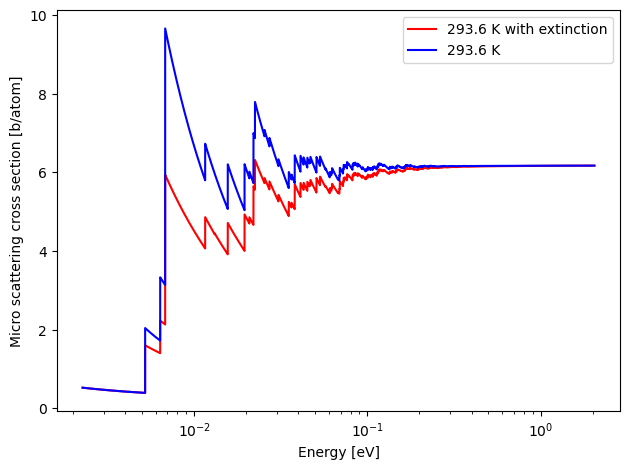

In [6]:
import numpy as np
import matplotlib.pyplot as plt

wl = np.linspace(0.2, 6, 10000) #Wavelengths, Aa

#Define NCrystal cfg-strings:
cfg_std = 'stdlib::Be_sg194.ncmat;temp=293.6K'
cfg_extn = 'Be_sg194-CrysExtn.ncmat;temp=293.6K' #<-- the data we registered above

#Load as NCrystal objects:
mat_std = NC.load(cfg_std)
mat_extn = NC.load(cfg_extn)

#Plot cross sections:
plt.figure()
plt.plot(NC.wl2ekin(wl), mat_extn.xsect(wl=wl), 'r-', label='293.6 K with extinction')
plt.plot(NC.wl2ekin(wl), mat_std.xsect(wl=wl), 'b-', label='293.6 K')
plt.legend()
plt.xscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Micro scattering cross section [b/atom]')
plt.show()

Now we will setup up the parameters for the ncmat2endf script.

If we try to do this blindly, we will get an error:

* `ERROR: Material configuration indicates scattering processes which has not been vetted for conversion to the ENDF format: "CrysExtnModel"`

This is because the code in `ncmat2endf` only knows about physics models from NCrystal itself, not those made available via a plugin. To get around this, we currently have to use a somewhat nasty hack, adding the `CrysExtnModel` to the list of models that `ncmat2endf` will accept (NOTE: This hack will be formalised in a future NCrystal release!):

In [7]:
from NCrystal import _ncmat2endf_impl
_ncmat2endf_impl.allowed_scat_proc_names.add('CrysExtnModel')

Now we can finally start on exporting the material with extinction to ENDF. First we will fill out the relevant ENDF metadata.

In [8]:
from NCrystal import ncmat2endf
m = ncmat2endf.EndfMetaData()
m.set_value("alab","MyLabName")
m.set_value("libname","NuclearDataLibraryName")
m.set_value("auth","AuthorNames")
m.set_value("nlib",2)
m.set_value("matnum",{"Be":26})

Now generate the ENDF output (using force=True to avoid an error if rerunning the notebook).

In [9]:
res = ncmat2endf.ncmat2endf(cfg_extn,endf_metadata=m, smin=5e-98, force=True)

Initialise nuclear data...
Write ENDF file tsl_Be.endf ...
Files created:
  tsl_Be.endf : Be with fraction 1
Suggested material density: 1.844653888 g/cm^3


In [10]:
import pprint
pprint.pprint(res)

{'density': 1.8446538883277912,
 'files': [{'component': 'Be', 'file': 'tsl_Be.endf', 'fraction': 1.0}],
 'temperature': 293.6}


Now we can use a small utility script to invoke NJOY in order to create an ACE file from the ENDF file we just produced.

In [11]:
from ncrystal_notebook_utilities.endf2ace import convert_endf_tsl_to_ace

endf_fn = 'tsl_Be.endf'
ace_fn = 'c_Be-293.6K.ace'
ace_fn, xsdir_fn = convert_endf_tsl_to_ace(endf_fn, ace_filename=ace_fn,ace_name='c_Be')

Use OpenMC to plot the data and compare against the NCrystal calculated cross-section.

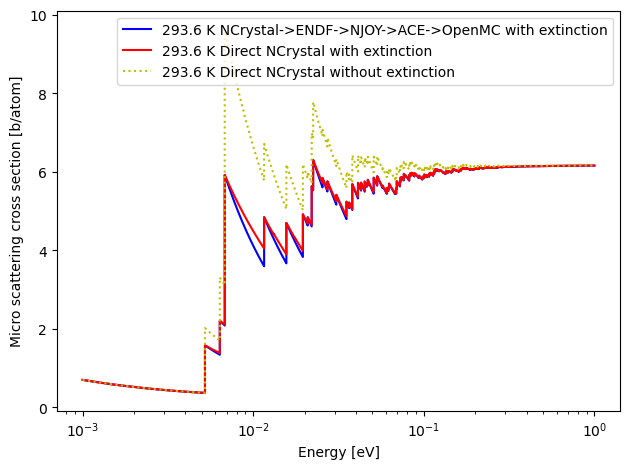

In [12]:
energy = np.geomspace(1e-3, 1.0,100000)

import openmc
thermal_data = openmc.data.ThermalScattering.from_ace('c_Be-293.6K.ace')
ace_elastic_xs = thermal_data.elastic.xs['294K']
ace_inelastic_xs = thermal_data.inelastic.xs['294K']
ace_total_xs = ace_elastic_xs(energy) + ace_inelastic_xs(energy)

plt.figure()
plt.plot(energy, ace_total_xs, 'b-', label='293.6 K NCrystal->ENDF->NJOY->ACE->OpenMC with extinction')
plt.plot(energy, mat_extn.scatter.xsect(energy), 'r-', label='293.6 K Direct NCrystal with extinction')
plt.plot(energy, mat_std.scatter.xsect(energy), 'y:', label='293.6 K Direct NCrystal without extinction')
plt.legend()
plt.xscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Micro scattering cross section [b/atom]')
plt.show()


It is seen that the data from the ENDF file does to some degree account for the extinction, but that it can not reproduce the exact behavior between Bragg edges. This is because the ENDF format can only accomodate extinction models by "shoe-horning" them into standard Bragg edge shapes. More complicated extinction models, including those accounting for secondary extinction, are likely to fare even worse.